# Часть 2: Применение современных NLP-моделей (стемминг, лемматизация)

# 1. Загрузка данных и составление датасета

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
dataset = pd.read_csv("/content/drive/MyDrive/full_dataset.csv")

In [4]:
text = dataset['cleaned_text'].tolist()
real = dataset['real'].tolist()

# 2. Здесь экспериментируем со стеммингом и лемматизацией

In [5]:
import nltk
from nltk.tokenize import word_tokenize
import re
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt_tab')
stop_words = list(set(stopwords.words("english")))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [6]:
def stopwords_special(text):
  text = text.lower()
  tokens = word_tokenize(text)
  tokens = [word for word in tokens if word not in stop_words]  # убираем стоп-слова
  tokens = word_tokenize(re.sub(r'[^a-zA-Zа-яА-Я ]', '', ' '.join(tokens)))  # убираем спец символы, числа и знаки препинания
  return tokens

In [7]:
nltk.download('wordnet')
nltk.download('omw-1.4')

# стемминг
def stemming(text):
  tokens = stopwords_special(text)
  stemmer = nltk.PorterStemmer()  # инициализируем стеммер
  stemmed_tokens = [stemmer.stem(token) for token in tokens]  # перебираем токены и применяем алгоритм стемминга

  return stemmed_tokens

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [8]:
def lemma(text):
  tokens = stopwords_special(text)
  lemmatizer = nltk.WordNetLemmatizer()
  lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]

  return lemmatized_tokens

In [9]:
text_stem = [' '.join(stemming(d)) for d in text]

In [10]:
text_lemma = [' '.join(lemma(d)) for d in text]

# 3. Подключение библиотек и токенизация, обучение модели - стемминг

In [1]:
from tensorflow.keras.preprocessing.text import Tokenizer  # токенезация текста
from tensorflow.keras.preprocessing.sequence import pad_sequences  # выравнивание последовательности до одной длины
from tensorflow.keras.models import Sequential  # линейные слои
from tensorflow.keras.layers import Embedding, LSTM, Dense, Input, GlobalMaxPooling1D, Dropout
from sklearn.metrics import accuracy_score, f1_score
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

In [11]:
X_train_stem, X_test_stem, y_train_stem, y_test_stem = train_test_split(text_stem, real, test_size=0.2, random_state=42)

In [12]:
token_stem = Tokenizer()
token_stem.fit_on_texts(X_train_stem)

In [13]:
word_idx_stem = token_stem.word_index
v_stem = len(word_idx_stem)
print("Размер словаря = ", v_stem)

Размер словаря =  138858


In [14]:
X_train_stem = token_stem.texts_to_sequences(X_train_stem)
X_test_stem = token_stem.texts_to_sequences(X_test_stem)

In [15]:
X_train_stem = pad_sequences(X_train_stem, maxlen=250)
X_test_stem = pad_sequences(X_test_stem, maxlen=250)

In [16]:
# модель
input3 = Input(shape=(250,))
learning_rate = 1e-4

x = Embedding(v_stem+1,100)(input3)
x = Dropout(0.5)(x)
x = LSTM(150,return_sequences=True)(x)
x = Dropout(0.5)(x)
x = GlobalMaxPooling1D()(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(2, activation='softmax')(x)

model_stem = Model(input3, x)

# Оптимайзер
optimizer = Adam(learning_rate=learning_rate)

model_stem.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [17]:
model_stem.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 250)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 250, 100)       │    13,885,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 250, 100)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 250, 150)       │       150,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 250, 150)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 150)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         9,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,046,294 (53.58 MB)

 Trainable params: 14,046,294 (53.58 MB)

 Non-trainable params: 0 (0.00 B)

In [18]:
from sklearn.preprocessing import LabelEncoder

label_encoder_stem = LabelEncoder()
y_train_encoded_stem = label_encoder_stem.fit_transform(y_train_stem)
y_test_encoded_stem = label_encoder_stem.transform(y_test_stem)

In [19]:
import tensorflow
y_train_one_hot_stem = tensorflow.keras.utils.to_categorical(y_train_encoded_stem)
y_test_one_hot_stem = tensorflow.keras.utils.to_categorical(y_test_encoded_stem)

In [20]:
history_stem = model_stem.fit(X_train_stem, y_train_one_hot_stem, epochs=15, validation_data=(X_test_stem, y_test_one_hot_stem))

Epoch 1/15
750/750 ━━━━━━━━━━━━━━━━━━━━ 589s 779ms/step - accuracy: 0.6291 - loss: 0.6240 - val_accuracy: 0.8670 - val_loss: 0.4019
Epoch 2/15
750/750 ━━━━━━━━━━━━━━━━━━━━ 634s 796ms/step - accuracy: 0.8874 - loss: 0.3050 - val_accuracy: 0.9015 - val_loss: 0.2946
Epoch 3/15
750/750 ━━━━━━━━━━━━━━━━━━━━ 626s 801ms/step - accuracy: 0.9348 - loss: 0.1960 - val_accuracy: 0.9136 - val_loss: 0.2604
Epoch 4/15
750/750 ━━━━━━━━━━━━━━━━━━━━ 610s 786ms/step - accuracy: 0.9591 - loss: 0.1320 - val_accuracy: 0.9200 - val_loss: 0.2397
Epoch 5/15
750/750 ━━━━━━━━━━━━━━━━━━━━ 631s 797ms/step - accuracy: 0.9695 - loss: 0.0987 - val_accuracy: 0.9216 - val_loss: 0.2239
Epoch 6/15
750/750 ━━━━━━━━━━━━━━━━━━━━ 599s 799ms/step - accuracy: 0.9785 - loss: 0.0710 - val_accuracy: 0.9213 - val_loss: 0.2112
Epoch 7/15
750/750 ━━━━━━━━━━━━━━━━━━━━ 612s 786ms/step - accuracy: 0.9827 - loss: 0.0595 - val_accuracy: 0.9205 - val_loss: 0.2114
Epoch 8/15
750/750 ━━━━━━━━━━━━━━━━━━━━ 601s 802ms/step - accuracy: 0.9865 -

In [21]:
loss_stem, accuracy_stem = model_stem.evaluate(X_test_stem, y_test_one_hot_stem)

print("Test Loss:", loss_stem)
print("Test Accuracy:", accuracy_stem)

188/188 ━━━━━━━━━━━━━━━━━━━━ 33s 178ms/step - accuracy: 0.9182 - loss: 0.2067
Test Loss: 0.21103128790855408
Test Accuracy: 0.9198065996170044


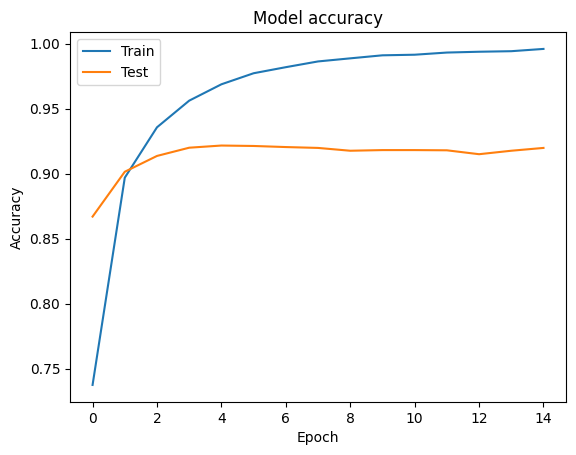

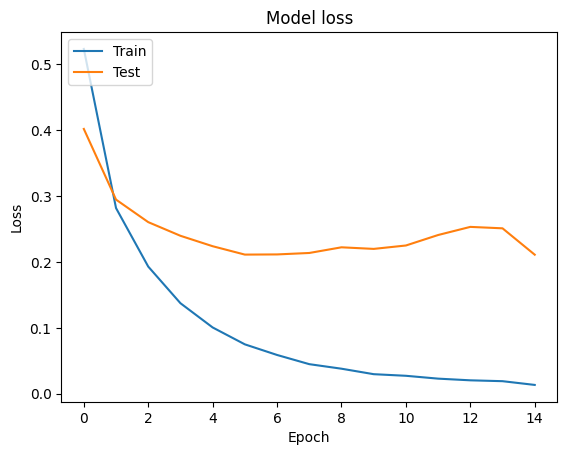

In [22]:
import matplotlib.pyplot as plt

# accuracy на train И val
plt.plot(history_stem.history['accuracy'])
plt.plot(history_stem.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# lossы на train и val
plt.plot(history_stem.history['loss'])
plt.plot(history_stem.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

**При применении LSTM и предобработки в виде стемминга, accuracy = 0.9198**

# 4. Токенезация текста, обучение модели - лемматизация

In [23]:
X_train_lemma, X_test_lemma, y_train_lemma, y_test_lemma = train_test_split(text_lemma, real, test_size=0.2, random_state=42)

In [24]:
token_lemma = Tokenizer()
token_lemma.fit_on_texts(X_train_lemma)

In [25]:
word_idx_lemma = token_lemma.word_index
v_lemma = len(word_idx_lemma)
print("Размер словаря = ", v_lemma)

Размер словаря =  159880


In [26]:
X_train_lemma = token_lemma.texts_to_sequences(X_train_lemma)
X_test_lemma = token_lemma.texts_to_sequences(X_test_lemma)

In [27]:
X_train_lemma = pad_sequences(X_train_lemma, maxlen=250)
X_test_lemma = pad_sequences(X_test_lemma, maxlen=250)

In [28]:
# модель
input4 = Input(shape=(250,))
learning_rate = 1e-4

x = Embedding(v_lemma+1,100)(input4)
x = Dropout(0.5)(x)
x = LSTM(150,return_sequences=True)(x)
x = Dropout(0.5)(x)
x = GlobalMaxPooling1D()(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(2, activation='softmax')(x)

model_lemma = Model(input4, x)

# Оптимайзер
optimizer = Adam(learning_rate=learning_rate)

model_lemma.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [29]:
model_lemma.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 250)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_1 (Embedding)         │ (None, 250, 100)       │    15,988,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 250, 100)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 250, 150)       │       150,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 250, 150)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_1          │ (None, 150)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         9,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,148,494 (61.60 MB)

 Trainable params: 16,148,494 (61.60 MB)

 Non-trainable params: 0 (0.00 B)

In [30]:
label_encoder_lemma = LabelEncoder()
y_train_encoded_lemma = label_encoder_lemma.fit_transform(y_train_lemma)
y_test_encoded_lemma = label_encoder_lemma.transform(y_test_lemma)

In [31]:
y_train_one_hot_lemma = tensorflow.keras.utils.to_categorical(y_train_encoded_lemma)
y_test_one_hot_lemma = tensorflow.keras.utils.to_categorical(y_test_encoded_lemma)

In [32]:
history_lemma = model_lemma.fit(X_train_lemma, y_train_one_hot_lemma, epochs=15, validation_data=(X_test_lemma, y_test_one_hot_lemma))

Epoch 1/15
750/750 ━━━━━━━━━━━━━━━━━━━━ 600s 795ms/step - accuracy: 0.6627 - loss: 0.6087 - val_accuracy: 0.8663 - val_loss: 0.4223
Epoch 2/15
750/750 ━━━━━━━━━━━━━━━━━━━━ 626s 801ms/step - accuracy: 0.8968 - loss: 0.2913 - val_accuracy: 0.9093 - val_loss: 0.3010
Epoch 3/15
750/750 ━━━━━━━━━━━━━━━━━━━━ 612s 816ms/step - accuracy: 0.9413 - loss: 0.1785 - val_accuracy: 0.9176 - val_loss: 0.2578
Epoch 4/15
750/750 ━━━━━━━━━━━━━━━━━━━━ 606s 795ms/step - accuracy: 0.9640 - loss: 0.1180 - val_accuracy: 0.9193 - val_loss: 0.2319
Epoch 5/15
750/750 ━━━━━━━━━━━━━━━━━━━━ 624s 798ms/step - accuracy: 0.9769 - loss: 0.0790 - val_accuracy: 0.9176 - val_loss: 0.2182
Epoch 6/15
750/750 ━━━━━━━━━━━━━━━━━━━━ 639s 821ms/step - accuracy: 0.9845 - loss: 0.0548 - val_accuracy: 0.9178 - val_loss: 0.2266
Epoch 7/15
750/750 ━━━━━━━━━━━━━━━━━━━━ 614s 810ms/step - accuracy: 0.9868 - loss: 0.0445 - val_accuracy: 0.9218 - val_loss: 0.2029
Epoch 8/15
750/750 ━━━━━━━━━━━━━━━━━━━━ 628s 818ms/step - accuracy: 0.9905 -

In [33]:
loss_lemma, accuracy_lemma = model_lemma.evaluate(X_test_lemma, y_test_one_hot_lemma)

print("Test Loss:", loss_lemma)
print("Test Accuracy:", accuracy_lemma)

188/188 ━━━━━━━━━━━━━━━━━━━━ 32s 168ms/step - accuracy: 0.9209 - loss: 0.2101
Test Loss: 0.21958959102630615
Test Accuracy: 0.9194731712341309


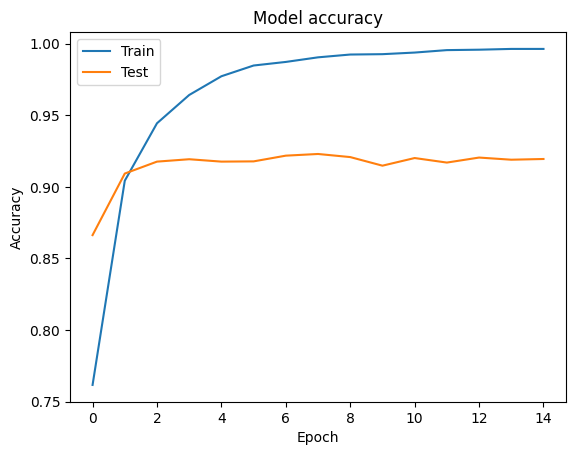

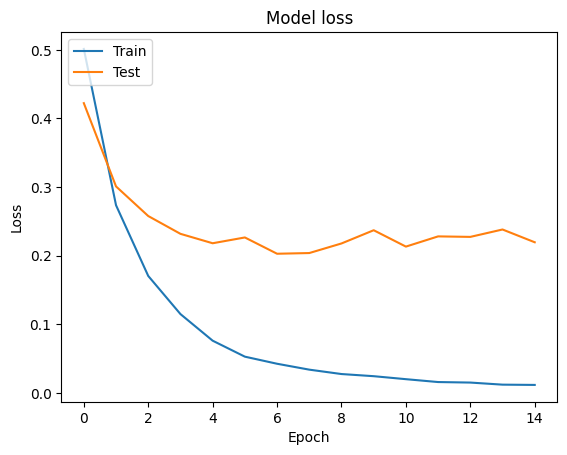

In [34]:
plt.plot(history_lemma.history['accuracy'])
plt.plot(history_lemma.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# lossы на train и val
plt.plot(history_lemma.history['loss'])
plt.plot(history_lemma.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

**При применении LSTM и предобработки в виде стемминга, accuracy = 0.9195**